In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import multiprocessing
from multiprocessing.pool import ThreadPool
import copy

import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import tqdm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from xgboost import XGBRegressor as xgb
from lightgbm import LGBMRegressor as lgbm
from catboost import CatBoostRegressor as cat
from sklearn.metrics import r2_score

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA

In [3]:
from data_io import load_data_by_ticker, get_call_data_for_given_ticker, display_all, display_shape, calls_amount

In [4]:
import matplotlib.font_manager as font_manager

font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

plt.rcParams['font.family'] = 'NanumGothic'

# Load data

In [5]:
df_input = pd.read_pickle('data/CALLS_FINAL.pkl')
display(df_input.head())
display(df_input.tail())

,월,요일,평균기온,최고기온,최저기온,일강수량,평균풍속,최다풍향,평균상대습도,가조시간,...,"중랑구, 50대, 여","중랑구, 60대, 남","중랑구, 60대, 여",족발/보쌈전문,중국음식,치킨,피자,합계,인터넷쇼핑,모바일쇼핑
key_0,,,,,,,,,,,,,,,,,,,,,
2013-08-01,8.0,목요일,28.0,24.5,32.1,0.0,1.7,50.0,67.3,14.1,...,55.0,NaN,6.0,2989.0,29310.0,21906.0,6624.0,"3,162,920","2,582,185","580,735"
2013-08-02,8.0,금요일,27.4,25.2,29.3,7.5,2.0,50.0,80.4,14.1,...,44.0,10.0,18.0,3389.0,30199.0,27457.0,8091.0,"3,162,920","2,582,185","580,735"
2013-08-03,8.0,토요일,28.9,26.7,32.6,0.1,3.7,230.0,72.3,14.0,...,48.0,17.0,19.0,3935.0,35965.0,32984.0,9601.0,"3,162,920","2,582,185","580,735"
2013-08-04,8.0,일요일,28.3,26.4,31.3,4.5,2.4,250.0,76.4,14.0,...,46.0,16.0,14.0,3682.0,36219.0,31856.0,10519.0,"3,162,920","2,582,185","580,735"
2013-08-05,8.0,월요일,27.7,26.4,30.1,7.0,3.2,230.0,78.9,14.0,...,28.0,8.0,12.0,2645.0,27561.0,19661.0,6318.0,"3,162,920","2,582,185","580,735"


,월,요일,평균기온,최고기온,최저기온,일강수량,평균풍속,최다풍향,평균상대습도,가조시간,...,"중랑구, 50대, 여","중랑구, 60대, 남","중랑구, 60대, 여",족발/보쌈전문,중국음식,치킨,피자,합계,인터넷쇼핑,모바일쇼핑
key_0,,,,,,,,,,,,,,,,,,,,,
2019-08-27,8.0,화요일,25.7,22.2,29.3,20.0,1.0,290.0,71.1,13.2,...,8.0,8.0,10.0,2359.0,10162.0,8168.0,3832.0,"11,190,709","3,943,856","7,246,854"
2019-08-28,8.0,수요일,26.1,23.6,30.2,0.0,1.9,270.0,66.2,13.2,...,21.0,10.0,5.0,2341.0,10491.0,8694.0,3974.0,"11,190,709","3,943,856","7,246,854"
2019-08-29,8.0,목요일,23.4,20.1,26.4,36.9,2.2,160.0,77.1,13.1,...,18.0,11.0,10.0,2612.0,14513.0,9406.0,4543.0,"11,190,709","3,943,856","7,246,854"
2019-08-30,8.0,금요일,22.6,19.5,27.0,0.2,2.4,200.0,66.3,13.1,...,25.0,10.0,8.0,2959.0,11548.0,12604.0,5118.0,"11,190,709","3,943,856","7,246,854"
2019-08-31,8.0,토요일,23.5,18.5,28.9,0.0,1.9,230.0,65.0,13.1,...,24.0,17.0,13.0,2876.0,13445.0,13597.0,5925.0,"11,190,709","3,943,856","7,246,854"


In [6]:
target_mtd = pd.read_csv('metadata/target_kospi.csv')
target_mtd['코드'] = target_mtd['코드'].apply(lambda x: str(int(x)).zfill(6))
target_mtd.columns = [x.replace('품목', '기업명') for x in target_mtd.columns]
target_mtd = target_mtd[['코드', '기업명']]
display(target_mtd.head())
display(target_mtd.tail())

,코드,기업명
0,009240,한샘
1,079430,현대리바트
2,021240,웅진코웨이
3,007310,오뚜기
4,017810,풀무원


,코드,기업명
20,080160,모두투어
21,044960,이글벳
22,086990,메디톡스
23,095700,제넥신
24,241590,화승엔터프라이즈


# Merge dataset

In [102]:
# hyperparamter

idx_ticker = 0
num_threads = 24

In [103]:
# load data

ticker = target_mtd['코드'][idx_ticker]
stock_price = pd.read_pickle('data/kospi/%s.data' % ticker)
stock_price.index = pd.to_datetime(stock_price.index)
stock_price = stock_price.drop(['Adj Close'], axis=1)
#stock_price = pd.DataFrame(stock_price[['Close']])
#other_components = stock_price[['Open', 'High', 'Low', 'Volume']]
stock_price

# merge wihtout time lag
df = stock_price.merge(df_input, how='inner', left_on=stock_price.index, right_on=df_input.index)
df.index = df['key_0']
df = df.drop(['key_0'], axis=1)

# preprocess (remove object columns)
for idx_day, day in enumerate(['월요일', '화요일', '수요일', '목요일', '금요일']) : 
    df['요일'] = df['요일'].apply(lambda x : idx_day if x==day else x)
for column in df.select_dtypes('object').columns : 
    df[column] = df[column].apply(lambda x : x.replace(',', ''))
    df[column] = pd.to_numeric(df[column])
    
display(df)
df.info()

,High,Low,Open,Close,Volume,월,요일,평균기온,최고기온,최저기온,...,"중랑구, 50대, 여","중랑구, 60대, 남","중랑구, 60대, 여",족발/보쌈전문,중국음식,치킨,피자,합계,인터넷쇼핑,모바일쇼핑
key_0,,,,,,,,,,,,,,,,,,,,,
2013-08-01,38500,37500,38100,38100,39946,8.0,3,28.0,24.5,32.1,...,55.0,NaN,6.0,2989.0,29310.0,21906.0,6624.0,3162920,2582185,580735
2013-08-02,38600,37050,38050,37300,40219,8.0,4,27.4,25.2,29.3,...,44.0,10.0,18.0,3389.0,30199.0,27457.0,8091.0,3162920,2582185,580735
2013-08-05,37500,36600,37500,37300,22050,8.0,0,27.7,26.4,30.1,...,28.0,8.0,12.0,2645.0,27561.0,19661.0,6318.0,3162920,2582185,580735
2013-08-06,37750,36900,37350,37750,17342,8.0,1,26.4,23.0,27.6,...,33.0,8.0,14.0,2721.0,29501.0,21253.0,7027.0,3162920,2582185,580735
2013-08-07,37750,36750,37750,36800,15674,8.0,2,28.7,25.0,32.1,...,37.0,8.0,16.0,2890.0,27303.0,22088.0,6356.0,3162920,2582185,580735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-26,63700,62100,62800,63000,61048,8.0,0,26.4,21.5,32.1,...,20.0,5.0,11.0,2167.0,9809.0,7603.0,3638.0,11190709,3943856,7246854
2019-08-27,63200,60900,63100,61400,88886,8.0,1,25.7,22.2,29.3,...,8.0,8.0,10.0,2359.0,10162.0,8168.0,3832.0,11190709,3943856,7246854
2019-08-28,62200,57900,61500,61800,223121,8.0,2,26.1,23.6,30.2,...,21.0,10.0,5.0,2341.0,10491.0,8694.0,3974.0,11190709,3943856,7246854


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1498 entries, 2013-08-01 to 2019-08-30
Columns: 330 entries, High to 모바일쇼핑
dtypes: float64(321), int64(9)
memory usage: 3.8 MB


In [104]:
df_original = copy.deepcopy(df)

# Build model to predict stock price 

In [105]:
# hyperparameter
time_shift = -5 # if time_shift = -5, 'Close' is price of 5 days later (future price)

In [106]:
# proprocess (if needed)
df = copy.deepcopy(df_original)

# target y (future price)
df['y'] = df['Close'].shift(time_shift)
df = df[df['y'].notnull()]
df = df[df.index <= datetime.datetime(2018,12,31)]

# split train/test
y = df['y'] # time-shifted future price
x = df.drop(['y', 'Open', 'High', 'Low'], axis=1) # contains today's price 'Close', 'Volume'
others = df[['Open', 'Close', 'High', 'Low', 'Volume']]
x_columns = x.columns

x_train = x[x.index < datetime.datetime(2017, 1, 1)].values
x_valid = x[x.index >= datetime.datetime(2017, 1, 1)].values
y_train = y[y.index < datetime.datetime(2017, 1, 1)].values
y_valid = y[y.index >= datetime.datetime(2017, 1, 1)].values
others_train = others[others.index < datetime.datetime(2017, 1, 1)]
others_valid = others[others.index >= datetime.datetime(2017, 1, 1)]
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

df

(840, 327) (493, 327) (840,) (493,)


,High,Low,Open,Close,Volume,월,요일,평균기온,최고기온,최저기온,...,"중랑구, 60대, 남","중랑구, 60대, 여",족발/보쌈전문,중국음식,치킨,피자,합계,인터넷쇼핑,모바일쇼핑,y
key_0,,,,,,,,,,,,,,,,,,,,,
2013-08-01,38500,37500,38100,38100,39946,8.0,3,28.0,24.5,32.1,...,NaN,6.0,2989.0,29310.0,21906.0,6624.0,3162920,2582185,580735,37400.0
2013-08-02,38600,37050,38050,37300,40219,8.0,4,27.4,25.2,29.3,...,10.0,18.0,3389.0,30199.0,27457.0,8091.0,3162920,2582185,580735,37450.0
2013-08-05,37500,36600,37500,37300,22050,8.0,0,27.7,26.4,30.1,...,8.0,12.0,2645.0,27561.0,19661.0,6318.0,3162920,2582185,580735,37700.0
2013-08-06,37750,36900,37350,37750,17342,8.0,1,26.4,23.0,27.6,...,8.0,14.0,2721.0,29501.0,21253.0,7027.0,3162920,2582185,580735,36800.0
2013-08-07,37750,36750,37750,36800,15674,8.0,2,28.7,25.0,32.1,...,8.0,16.0,2890.0,27303.0,22088.0,6356.0,3162920,2582185,580735,36000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,69700,66200,68600,68500,305537,12.0,4,5.6,0.4,9.8,...,15.0,18.0,3209.0,14309.0,14554.0,5935.0,10700489,3972797,6727693,67700.0
2018-12-24,68500,66100,68500,67000,115991,12.0,0,-2.3,-5.9,3.1,...,27.0,31.0,4000.0,13747.0,20617.0,8939.0,10700489,3972797,6727693,66000.0
2018-12-26,67200,65300,66000,65800,93293,12.0,2,-1.5,-7.1,3.0,...,7.0,15.0,2759.0,13157.0,9836.0,4665.0,10700489,3972797,6727693,68000.0


0.9998780028721942 0.9269134418794867


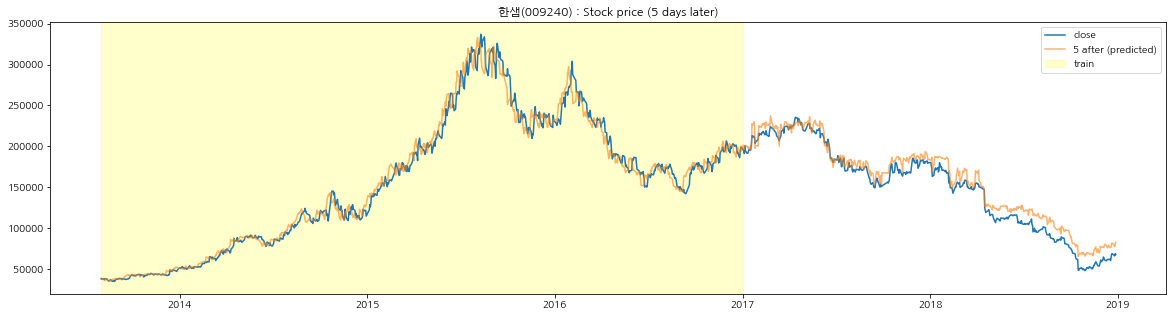

In [107]:
#model

model = lgbm(num_threads=num_threads)
#model = xgb(nthread=num_threads)
#model = cat(thread_count=num_threads, verbose=0)

model.fit(x_train, y_train)

y_train_hat = model.predict(x_train)
y_valid_hat = model.predict(x_valid)

print(r2_score(y_train, y_train_hat), r2_score(y_valid, y_valid_hat))


plt.figure(figsize=(20, 5))
plt.plot(df.index, others['Close'], label='close')
#plt.plot(df.index, pd.concat([pd.Series(y_train), pd.Series(y_valid)], ignore_index=True), label='%s after (close)' % (-time_shift))
plt.plot(df.index, pd.concat([pd.Series(y_train_hat), pd.Series(y_valid_hat)], ignore_index=True), label='%s after (predicted)' % (-time_shift), alpha=0.6)
plt.axvspan(df.index[0], df.index[len(y_train)], alpha=0.2, color='yellow', label='train')
plt.title('%s(%s) : Stock price (%s days later)' % (target_mtd['기업명'][idx_ticker], 
                                                    target_mtd['코드'][idx_ticker],
                                                   -time_shift))
plt.legend()
plt.show()

In [108]:
others_valid

,Open,Close,High,Low,Volume
key_0,,,,,
2017-01-02,199000,195500,199000,194500,20331
2017-01-03,196000,193000,196500,191500,42258
2017-01-04,193000,191000,193500,190500,32931
2017-01-05,197000,200500,201000,193000,84654
2017-01-06,198500,194500,200500,193500,49912
...,...,...,...,...,...
2018-12-21,68600,68500,69700,66200,305537
2018-12-24,68500,67000,68500,66100,115991
2018-12-26,66000,65800,67200,65300,93293


In [109]:
data = pd.DataFrame(x_valid, columns=x_columns)
data = data.merge(others_valid, how='inner')

yhat = model.predict(data.drop(['Open', 'High', 'Low'], axis=1))
data['time shfited'] = yhat

data

,Close,Volume,월,요일,평균기온,최고기온,최저기온,일강수량,평균풍속,최다풍향,...,중국음식,치킨,피자,합계,인터넷쇼핑,모바일쇼핑,Open,High,Low,time shfited
0,195500.0,20331.0,1.0,0.0,5.0,1.8,9.2,0.3,2.1,20.0,...,15827.0,12916.0,6572.0,7310479.0,3390183.0,3920295.0,199000,199000,194500,201388.610828
1,193000.0,42258.0,1.0,1.0,2.0,-2.3,7.7,0.0,1.8,270.0,...,16703.0,13527.0,7317.0,7310479.0,3390183.0,3920295.0,196000,196500,191500,195624.411647
2,191000.0,32931.0,1.0,2.0,3.9,1.0,8.9,0.0,1.7,270.0,...,17025.0,14280.0,7276.0,7310479.0,3390183.0,3920295.0,193000,193500,190500,195750.425197
3,200500.0,84654.0,1.0,3.0,3.8,-0.1,7.3,0.0,3.1,50.0,...,17725.0,14916.0,7412.0,7310479.0,3390183.0,3920295.0,197000,201000,193000,198777.461092
4,194500.0,49912.0,1.0,4.0,5.4,2.5,11.4,0.0,2.4,50.0,...,18436.0,19057.0,8472.0,7310479.0,3390183.0,3920295.0,198500,200500,193500,201083.067101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,68500.0,305537.0,12.0,4.0,5.6,0.4,9.8,0.0,1.1,70.0,...,14309.0,14554.0,5935.0,10700489.0,3972797.0,6727693.0,68600,69700,66200,81442.640880
501,67000.0,115991.0,12.0,0.0,-2.3,-5.9,3.1,0.0,1.6,290.0,...,13747.0,20617.0,8939.0,10700489.0,3972797.0,6727693.0,68500,68500,66100,79852.427030
502,65800.0,93293.0,12.0,2.0,-1.5,-7.1,3.0,0.0,2.8,290.0,...,13157.0,9836.0,4665.0,10700489.0,3972797.0,6727693.0,66000,67200,65300,77003.375938
503,68600.0,170009.0,12.0,3.0,-10.1,-12.5,-6.5,0.0,3.5,290.0,...,15184.0,11973.0,5440.0,10700489.0,3972797.0,6727693.0,66000,69900,66000,80634.107748


In [114]:
class SmaCross(Strategy) :
    def init(self) :
        print(self.data)
        # 한줄씩 호출되는듯
        #self.data = data
        self.close = self.data['Close']
        self.time_shifted_price = self.data['time shfited']
        self.daycount = 0
        self.hold = False
        
    def next(self) :  
        
        if (self.close < self.time_shifted_price) and (self.hold == False) :
            self.buy()
            self.hold = True
            self.daycount = 0
        
        self.daycount += 1
        
        if (self.daycount == 5) and (self.hold == True):
            self.sell()
            self.hold = False


In [115]:
bt = Backtest(data, SmaCross, cash=10000, commission=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Data index is not datetime. Assuming simple periods.
  """Entry point for launching an IPython kernel.


In [116]:
bt.run()

Start                             0
End                             504
Duration                        504
Exposure [%]                99.2063
Equity Final [$]             7409.5
Equity Peak [$]             12845.3
Return [%]                  -25.905
Buy & Hold Return [%]       65.5243
Max. Drawdown [%]          -64.6691
Avg. Drawdown [%]          -3.13284
Max. Drawdown Duration           21
Avg. Drawdown Duration         6.75
# Trades                        200
Win Rate [%]                     49
Best Trade [%]              11.6732
Worst Trade [%]            -20.8678
Avg. Trade [%]            -0.134059
Max. Trade Duration               4
Avg. Trade Duration             2.5
Expectancy [%]              2.83243
SQN                       -0.613417
Sharpe Ratio             -0.0334671
Sortino Ratio             -0.038262
Calmar Ratio              -0.002073
_strategy                  SmaCross
dtype: object

In [117]:
bt.plot()